## Score calculation from extracted scores

In [197]:
! pip -q install transformers
! pip -q install numpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [198]:
import os
import numpy as np
import re
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score
from transformers import AutoTokenizer

In [199]:
## Get the tokenizer for a model


model_map = {"cambridgeltl":"cambridgeltl/SapBERT-UMLS-2020AB-all-lang-from-XLMR",
             "dilbert":"beatrice-portelli/DiLBERT",
             "bert-fi":"TurkuNLP/bert-base-finnish-cased-v1",
             "biomed-roberta": "allenai/biomed_roberta_base",
             "bert-en": "google-bert/bert-base-cased",
             "bert-es": "dccuchile/bert-base-spanish-wwm-uncased",
             "biomed-es":"PlanTL-GOB-ES/roberta-base-biomedical-clinical-es"}


lang = "es"
split = "dev"
model = "xlm-roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_map.get(model,model))

In [200]:
from itertools import zip_longest

def flatten(xss):
    return [x for xs in xss for x in xs]

def reverse_annotations(text):
    """
    Reverse MEDDOCAN + deepL annotations
    E.g. Name: [#3 Joseo]
    to
    Name: Joseo
    """

    i = re.finditer(r'\[\#[0-9]{1,2}[ ].+?\]', text)
    ind = [[m.start(0),m.end(0)] for m in i]
    current_index=0
    parsed_text=""
    annotations=[]
    for start, end in ind:
        parsed_text = parsed_text + text[current_index:start]
        annot = text[start:end].split(" ")
        pii_class = annot[0].replace("[","")
        annot_text = " ".join(annot[1:]).replace("]","")
        parsed_text += annot_text
        current_index = end
        annotations.append([pii_class, len(parsed_text)-len(annot_text), len(parsed_text)])
    #print(annotations)
    return parsed_text, annotations

# Function to parse TSV data into (word, score) pairs
def parse_tsv_data(tsv_data):
    scores = []
    words = []
    for line in tsv_data.strip().split('\n'):
        score, word, _ = line.split("\t",2)
        scores.append(float(score))
        words.append(str(word))
    return scores, words

def create_annotation_token_mask(char_offsets, detokenized, annotations_per_char, use_tags = False):
    """Create a vector with values corresponding to each token-annotation pair."""
    current_annot = 0
    continuation = False
    annotation_mask = []
    for token, (start, end) in zip(detokenized, char_offsets):
        try:
            c_type, c_start, c_end = annotations_per_char[current_annot]
        except IndexError:
            c_type, c_start, c_end = "#0",0,0
        if start == c_start or continuation:
            continuation=False
            if c_end > end:
                continuation = True
                #print(f"{token} [{start}, {end}] \t {c_type}")
                annotation_mask.append(c_type if use_tags else int(c_type[1:]))
                continue
            #print(f"{token} [{start}, {end}] \t {c_type}")
            annotation_mask.append(c_type if use_tags else int(c_type[1:]))
            current_annot += 1
        else:
            #print(f"{token} [{start}, {end}]")
            annotation_mask.append(None if use_tags else 0)
    return annotation_mask


def create_redaction_word_mask(scores, th):
    """Create a mask to see which words should be redacted."""
    return [1 if float(s) < th else 0 for s in scores]


def calculate_metrics(files):

    full_dev_scores = []
    full_dev_annotation_mask = []
    full_input_ids = []

    for file in files:
        try:
            #print("\n", file)
            file_annot = file.replace(f"zeroshot/scores_by_token/{lang}/{split}/{model}",f"deepl/translated_with_annotations/{lang}/{split}").replace("_by_token.tsv", ".txt")
            with open(file,"r") as f:
                scores = f.read()
            with open(file_annot, "r") as f:
                annots = f.read()

            # parse scored words
            scores, words = parse_tsv_data(scores)
            #print(words)
            # un-annotate, get annotations as locations by char
            parsed_original_text, annotations_per_char = reverse_annotations(annots)
            # tokenize un-annotated text, return character indices
            tokenized = tokenizer(parsed_original_text, return_offsets_mapping=True)
            char_offsets = tokenized["offset_mapping"]
            # get token divisions
            retokens = tokenizer.convert_ids_to_tokens(tokenized["input_ids"])
            annotation_token_mask = create_annotation_token_mask(char_offsets, retokens, annotations_per_char)
            #print(f"scores {len(scores)}, tokenized {len(tokenized["input_ids"])}")

            
            additional_removal = [6] if model=="xlm-roberta-base" else []
            annotation_token_mask = [i for i,v in zip(annotation_token_mask,tokenized["input_ids"]) if v not in tokenizer.all_special_ids + additional_removal]
            full_input_ids.append([i for i in tokenized["input_ids"] if i not in tokenizer.all_special_ids + additional_removal])
            
            prev_i = ""
            for ind,(i,j,k) in enumerate(zip_longest(words, annotation_token_mask, full_input_ids[-1])):
                ret = tokenizer.decode(k)
                if i != ret:
                    if i == prev_i:   # common error in xlm-r
                        words.pop(ind)   # duplicate word
                        scores.pop(ind)   # duplicate score <- this is because of the context masking
                prev_i = i
                #print(i,j,tokenizer.decode(k))
            
            assert len(annotation_token_mask) == len(words), f"annotations {len(annotation_token_mask)}, words {len(words)}"
            #print(annotation_token_mask)

            # now, move from token to word level!
            #current_idx = -1
            #annotation_word_mask = []
            #for w_idx, mask, ret in zip(tokenized.word_ids(), annotation_token_mask, retokens):
            #    if w_idx is not None:
            #        if w_idx != current_idx:
            #            print(f"{words[w_idx]} \t {scores[w_idx]} \t {mask if mask is not None else ''} ({ret})")
            #           #annotation_word_mask.append(mask)
            #            current_idx = w_idx
            #        else:
            #            print(f"\t{words[w_idx]} \t {scores[w_idx]} \t {mask if mask is not None else ''} ({ret})")
            #assert len(annotation_word_mask) == len(words), f"{len(annotation_word_mask)} != {len(words)}" # (==len(scores), but we know that from previous)
            annotation_word_mask = annotation_token_mask
            # HERE TODO: select which tags to analyse
            annotation_word_mask = [1 if a > 0 else 0 for a in annotation_word_mask]
            #for w_, s_, a_ in zip(words, scores, annotation_word_mask):
            #    if "##" in w_:
            #        print(f"\t {w_}, {s_}, {a_ if a_ >0 else ''}")
            #    else:
            #        print((f"{w_}, {s_}, {a_ if a_ >0 else ''}"))
            assert len(annotation_token_mask) == len(words), f"annotations {len(annotation_token_mask)}, words {len(words)}"
            assert len(scores) == len(annotation_word_mask), f"scores {len(scores)}, annot {len(annotation_word_mask)}"
            full_dev_scores.append(scores)
            full_dev_annotation_mask.append(annotation_word_mask)
        except Exception as e:
            print(f'problem with {file}: {e}')
            if len(full_dev_annotation_mask) < len(full_input_ids):
                full_input_ids = full_input_ids[:-1]
    accuracies = []
    f1s = []
    recalls = []
    precisions = []
    rocs = []
    full_dev_scores_flattened = flatten(full_dev_scores)
    full_dev_annotation_mask_flattened = flatten(full_dev_annotation_mask)

    for th in np.logspace(0, -20, 100):
        redaction_word_mask = create_redaction_word_mask(full_dev_scores_flattened, th)
        accuracies.append(accuracy_score(full_dev_annotation_mask_flattened, redaction_word_mask))
        f1s.append(f1_score(full_dev_annotation_mask_flattened, redaction_word_mask,  average="binary"))
        recalls.append(recall_score(full_dev_annotation_mask_flattened, redaction_word_mask,  average="binary"))
        precisions.append(precision_score(full_dev_annotation_mask_flattened, redaction_word_mask, average="binary"))
        rocs.append(roc_auc_score(full_dev_annotation_mask_flattened, redaction_word_mask, average="micro"))
    print(accuracies)
    print(f1s)
    print(recalls)
    print(precisions)
    print(rocs)
    return accuracies, f1s, recalls, precisions, rocs, full_input_ids, full_dev_scores, full_dev_annotation_mask


In [201]:
file_paths = os.scandir(f"/scratch/project_2009498/dippa/zeroshot/scores_by_token/{lang}/{split}/{model}/")
files = [p.path for p in file_paths if "by_token.tsv" in p.path]
print(files)

['/scratch/project_2009498/dippa/zeroshot/scores_by_token/es/dev/xlm-roberta-base/S0211-69952011000400013-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/es/dev/xlm-roberta-base/S1130-05582009000600006-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/es/dev/xlm-roberta-base/S1130-05582015000100004-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/es/dev/xlm-roberta-base/S1130-01082005000800013-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/es/dev/xlm-roberta-base/S0365-66912009001100006-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/es/dev/xlm-roberta-base/S1699-695X2016000200009-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/es/dev/xlm-roberta-base/S0004-06142006000900009-1_by_token.tsv', '/scratch/project_2009498/dippa/zeroshot/scores_by_token/es/dev/xlm-roberta-base/S0378-48352006000600006-1_by_token.tsv', '/scratch/project_20094

In [202]:
tokenizer.all_special_ids

[0, 2, 3, 1, 250001]

In [203]:
accuracies, f1s, recalls, precisions, rocs, full_input_ids, full_dev_scores, full_dev_annotation_mask = calculate_metrics(files)

Token indices sequence length is longer than the specified maximum sequence length for this model (1287 > 512). Running this sequence through the model will result in indexing errors


problem with /scratch/project_2009498/dippa/zeroshot/scores_by_token/es/dev/xlm-roberta-base/S1131-57682001000100007-2_by_token.tsv: argument 'ids': 'NoneType' object cannot be converted to 'Sequence'
[0.07166006481814909, 0.20821029888368744, 0.25286280158444363, 0.28620813827871805, 0.3132877205617573, 0.3352538710839035, 0.357652142599928, 0.38019445444724526, 0.4026647461289161, 0.424198775657184, 0.44234785740007204, 0.46308966510622973, 0.4804465250270076, 0.5002520705797623, 0.517969031328772, 0.5339575081022686, 0.5505221462009363, 0.5698955707598128, 0.5886928339935182, 0.6044652502700756, 0.6206697875405114, 0.6345696795102629, 0.6485415916456608, 0.6611451206337775, 0.670507742167807, 0.6859200576161325, 0.6967230824630897, 0.7086784299603889, 0.7222902412675549, 0.7321570039611092, 0.7407274036730285, 0.7508822470291682, 0.7595966870723803, 0.7680230464530069, 0.7762333453366943, 0.7841555635577961, 0.7891249549873964, 0.7951746489016924, 0.8035289881166726, 0.8100108030248

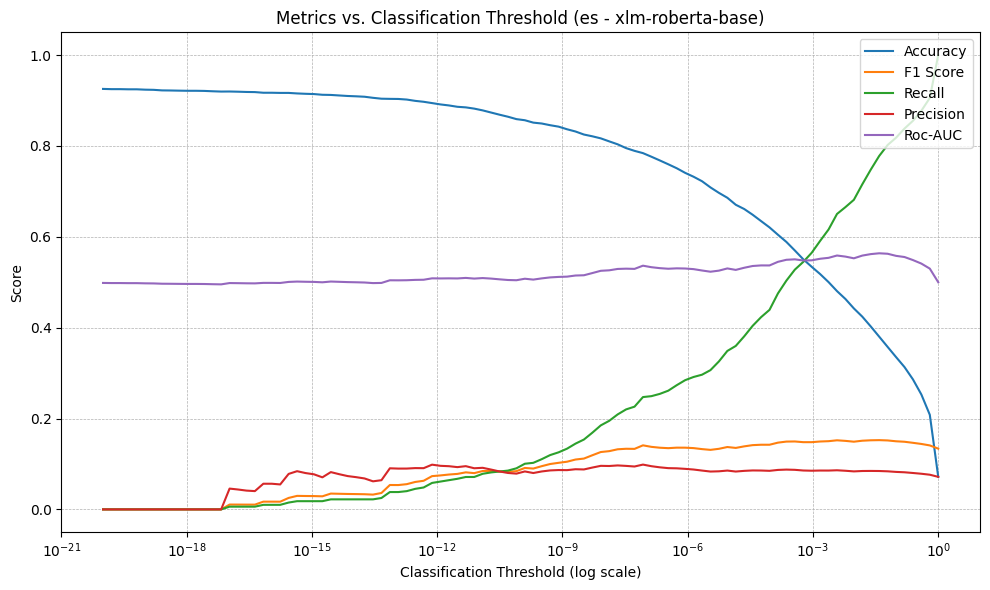

In [204]:
import matplotlib.pyplot as plt


def plot_metrics_vs_threshold(thresholds, accuracies, f1s, recalls, precisions, rocs):
    """
    Plots accuracy, F1 score, recall, and precision against classification thresholds (log scale).

    Parameters:
    - thresholds: array-like, shape (n,) – classification thresholds (logarithmic values)
    - accuracies, f1s, recalls, precisions: array-like, shape (n,) – metric values corresponding to each threshold
    """

    plt.figure(figsize=(10, 6))

    # Plot each metric
    plt.plot(thresholds, accuracies, label='Accuracy')#, marker='o')
    plt.plot(thresholds, f1s, label='F1 Score')#, marker='s')
    plt.plot(thresholds, recalls, label='Recall')#, marker='^')
    plt.plot(thresholds, precisions, label='Precision')#, marker='x')
    plt.plot(thresholds, rocs, label='Roc-AUC')#, marker='x')

    # Log scale for x-axis
    plt.xscale('log')

    # Labels and title
    plt.xlabel('Classification Threshold (log scale)')
    plt.ylabel('Score')
    plt.title(f'Metrics vs. Classification Threshold ({lang} - {model})')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics_vs_threshold(np.logspace(0, -20, 100), accuracies, f1s, recalls, precisions, rocs)

## EN - BERT-EN

![Alt text](kuva.png)

## EN - xlm-roberta-base 

![Alt text](kuva-3.png)

## FI - bert-fi

![Alt text](kuva-1.png)

## FI - xlm-roberta-base

![Alt text](kuva-4.png)

## ES - es-bert

![Alt text](kuva-2.png)

## Visualisation

In [205]:
! pip -q install IPython

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [206]:
from IPython.display import display, HTML
#import captum

"""
(Sentence as string+labels per character)
-> (array of words and label per word).
"""
def make_into_array(words, x):
  new_words = [""]
  new_x = np.array([0+0j])
  word_idx=0
  for letter, value in zip(words, x):
    if letter != " ": # word boundary
      new_words[word_idx]+=letter
      new_x[word_idx] = value
    else:
      word_idx += 1
      new_words.append("")
      new_x = np.append(new_x, 0+0j)
  assert len(new_words) == len(new_x)
  return new_words, new_x


"""
Rewrite form captum-library. Choose color based on attribute.
"""
def _get_color(attr):
    if attr == 1: # only in pred = red
        hue, sat, lig = 3, 100,	69
    elif attr == 1j: # only in true = yellow
        hue, sat, lig = 55, 90, 70
    elif attr == 1+1j:# both == green
        #hue, sat, lig = 120, 75,50
        hue, sat, lig = 120, 30, 70
    else:   # white
        hue, sat, lig = 10, 0, 100
    return "hsl({}, {}%, {}%)".format(hue, sat, lig)

def parse_token(t):
  if model in ["bert-fi", "bert-en", "bert-es"]:
    if "##" in t:
      return t[2:]
    else:
      return " "+t
  else:
    return t

"""
Rewrite from captum-library. Get formatting for html.
"""
def format_word_importances(words, importances):
    #words, importances = make_into_array(words,importances)
    if importances is None or len(importances) == 0:
        return "<td></td>"
    assert len(words) == len(importances), f"{len(words)} {len(importances)}"
    tags = ["<td>"]
    for word, importance in zip(words, importances):#[: len(words)]):
        #word = format_special_tokens(word)
        color = _get_color(importance)
        unwrapped_tag = '<mark style="background-color:{color}; opacity:1.0; \
                    line-height:1.75"><font color="black">{word}\
                    </font></mark>'.format(
            color=color, word=parse_token(tokenizer.decode(word))
        )
        tags.append(unwrapped_tag)
    tags.append("</td>")
    return "".join(tags)

"""
Highlight both correct answers and predictions.
Three colors => complex importances.
  real values = correct answer
  imaginary values = predicted answer
  both = predicted correctly

Displays as html.
"""
def display_both(dict):
  words = dict["context"]
  x_p = lambda x: dict["pred"]["start"]<= x <= dict["pred"]["end"]
  x_t = lambda x: dict["correct"]["start"]<= x <= dict["correct"]["end"]
  pred_x = np.array([1j*complex(x_p(i)) for i in range(len(words))])
  true_x = np.array([complex(x_t(i)) for i in range(len(words))])

  difference_x = true_x+pred_x
  y = format_word_importances(words,difference_x)
  display(HTML(y))

def display_predict_and_annot(text, predict, annot):
    #print(predict)
    #print(annot)
    pred_x = np.array(predict) #np.array([1j*complex(x_p(i)) for i in range(len(words))])
    true_x = np.array([1j if i == 1 else 0 for i in annot])
    difference_x = true_x+pred_x
    #print(difference_x)
    y = format_word_importances(text,difference_x)
    display(HTML(y))

In [207]:

for t, s, a in zip(full_input_ids, full_dev_scores, full_dev_annotation_mask):
    pred = s
    annot = a
    assert len(t) == len(pred)
    print(t)
    pred = create_redaction_word_mask(pred, 1e-6)

    display_predict_and_annot(t, pred, annot)
    print("--------------------------------")

[36986, 7, 146, 73912, 5, 541, 66520, 12, 116668, 11, 5, 91450, 150, 1140, 12, 48739, 622, 763, 5, 47052, 441, 12, 361, 187716, 176830, 5, 79518, 294, 12, 1105, 183262, 108620, 4633, 6849, 9343, 2624, 10258, 12, 313, 64, 151252, 7928, 11, 4, 17281, 4, 116, 527, 5, 24172, 3812, 64, 86389, 12, 8884, 5, 41935, 12, 49686, 2839, 5, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 729, 44586, 201890, 5, 55806, 8, 24, 91570, 12, 14608, 5, 241, 12409, 12, 9318, 5107, 3621, 31, 12, 276, 5, 4221, 1436, 8, 360, 17562, 31, 12, 4777, 34340, 30268, 5, 212731, 12, 8335, 12986, 9563, 31, 3566, 34530, 438, 78457, 12, 1372, 1372, 7657, 103705, 5, 29833, 13, 202654, 146, 73912, 12, 2758, 4227, 8, 9318, 5107, 158, 177047, 5286, 117755, 8, 215871, 59522, 965, 113, 473, 56916, 7, 146, 26944, 51494, 1299, 5, 128198, 7636, 85, 8, 28, 18908, 27578, 1814, 142, 3181, 2400, 2733, 335, 3768, 47039, 22, 4078, 113, 22, 45231, 158, 1243, 3141, 316, 2055, 3287, 20907, 73913, 8, 54061, 88, 45231, 4, 220, 90871, 

--------------------------------
[541, 66520, 12, 5710, 54012, 5, 91450, 150, 1140, 12, 7712, 5, 9343, 2624, 10258, 12, 12982, 14, 12421, 17119, 4, 496, 4, 22221, 17678, 8671, 55372, 5, 24172, 3812, 64, 86389, 12, 79256, 5, 41935, 12, 43877, 17331, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 1438, 64024, 78972, 5, 55806, 12, 5596, 5, 241, 12409, 12, 744, 5107, 3621, 31, 12, 276, 5, 4221, 1436, 8, 360, 17562, 31, 12, 702, 88469, 1819, 5, 212731, 12, 19295, 5997, 145, 395, 71541, 5, 28107, 100582, 12, 4228, 44543, 3886, 8, 744, 5107, 8, 34007, 11668, 47189, 196, 6079, 16211, 21859, 47898, 22, 388, 68, 5286, 40908, 31, 9, 59104, 14, 19058, 54347, 3391, 388, 20220, 305, 11550, 5, 239, 73912, 6416, 15005, 3290, 134159, 7, 8, 3052, 15948, 113, 220, 128839, 224, 686, 4117, 8, 388, 68, 5286, 5, 438, 26708, 31, 65350, 7, 8, 5618, 4134, 36, 5225, 5, 98873, 42, 4117, 40621, 12, 992, 52550, 4537, 91, 97907, 46029, 8, 21, 73912, 110, 456, 272, 4380, 80230, 2373, 2749, 3290, 5, 239, 6422

--------------------------------
[36986, 7, 146, 73912, 5, 541, 66520, 12, 154928, 5, 91450, 150, 1140, 12, 33058, 147, 151797, 5, 47052, 441, 12, 190, 157041, 201208, 5, 79518, 294, 12, 6260, 206347, 190076, 6873, 1496, 5, 9343, 2624, 10258, 12, 313, 64, 7465, 139352, 8, 95, 840, 4, 53472, 5, 24172, 3812, 64, 86389, 12, 8884, 5, 41935, 12, 49686, 4235, 5, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 952, 66540, 163435, 5, 55806, 8, 24, 91570, 12, 14608, 5, 241, 12409, 12, 1496, 5107, 3621, 31, 12, 276, 5, 4221, 1436, 8, 360, 17562, 31, 12, 702, 185572, 5, 212731, 12, 5379, 129418, 6565, 19164, 438, 78457, 12, 1372, 1372, 138, 174543, 5442, 29833, 13, 202654, 146, 73912, 12, 44543, 8, 1496, 5107, 8, 34007, 4, 110, 35666, 46702, 300, 52224, 11606, 8, 57913, 4, 880, 177047, 5286, 202654, 7, 8, 59174, 4, 41, 110, 167028, 110261, 7, 94524, 300, 569, 11780, 10566, 22129, 37171, 7, 113, 41, 11668, 112, 10, 13130, 22921, 121, 11311, 184, 220, 1119, 132571, 1883, 146, 4809, 479, 432

--------------------------------
[36986, 7, 146, 73912, 5, 541, 66520, 12, 2777, 3521, 5, 91450, 150, 1140, 12, 786, 944, 106833, 219, 5, 47052, 441, 12, 176830, 5757, 12977, 5, 79518, 294, 12, 9365, 163544, 4633, 163544, 496, 5, 9343, 2624, 10258, 12, 313, 64, 96280, 7, 8, 353, 330, 4, 4442, 4, 483, 4, 62, 5, 24172, 3812, 64, 86389, 12, 97033, 1409, 11, 4, 10934, 1883, 5, 41935, 12, 137970, 14664, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 209, 40868, 127050, 5, 55806, 8, 24, 91570, 12, 14608, 5, 241, 12409, 12, 714, 5107, 3621, 31, 12, 276, 5, 4221, 1436, 8, 360, 17562, 31, 12, 387, 45828, 7735, 5, 88989, 12, 799, 7079, 50547, 5, 208519, 846, 12, 382, 162082, 192531, 5, 212731, 12, 6524, 1883, 193095, 66995, 438, 78457, 12, 496, 496, 10149, 127892, 5, 29833, 13, 202654, 146, 73912, 12, 2758, 4227, 8, 714, 5107, 4, 880, 177047, 5286, 8, 59174, 4, 41, 198, 122800, 85, 196, 18691, 220, 4816, 8, 3052, 176583, 8, 1653, 306, 9635, 22, 40701, 587, 29887, 31, 47870, 5, 129380, 2

--------------------------------
[541, 66520, 12, 30839, 5, 91450, 150, 1140, 12, 197207, 6470, 5, 47052, 441, 12, 2678, 178058, 5, 79518, 294, 12, 2678, 153781, 146560, 7709, 14154, 5, 9343, 2624, 10258, 12, 26265, 13, 8, 21, 17466, 4, 9559, 24172, 3812, 64, 86389, 12, 313, 12409, 5, 5120, 5, 41935, 22618, 135401, 5, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 3843, 44270, 97057, 5, 55806, 12, 14608, 5, 241, 12409, 12, 4669, 5107, 3621, 31, 12, 572, 5, 4221, 1436, 8, 360, 17562, 31, 12, 1381, 40868, 3259, 5, 88989, 12, 176800, 28122, 14108, 5, 212731, 12, 73638, 2071, 763, 26265, 2746, 438, 78457, 12, 702, 702, 16064, 156918, 5, 28107, 146, 73912, 12, 3323, 5800, 8, 4669, 5107, 47710, 58507, 131803, 144, 41, 4, 22, 220, 64222, 1150, 33864, 6232, 4, 40, 117042, 849, 220, 112011, 18440, 31, 25667, 15, 15185, 670, 16, 8, 4442, 2866, 841, 177, 22, 88, 36, 513, 47870, 15, 43740, 16, 113, 8, 2789, 2866, 841, 177, 22, 88, 36, 513, 445, 124608, 246, 15, 56272, 194, 239, 738, 5305,

--------------------------------
[36986, 7, 146, 73912, 5, 541, 66520, 12, 6470, 5, 91450, 150, 1140, 12, 229724, 3561, 62175, 5, 47052, 441, 12, 496, 18949, 2588, 966, 5, 9343, 2624, 10258, 12, 26265, 13, 23643, 85222, 241, 9254, 67, 4, 106, 4, 138, 284, 5, 24172, 3812, 64, 86389, 12, 8884, 5, 41935, 12, 49686, 4235, 5, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 4777, 48409, 16396, 5, 55806, 12, 14608, 5, 241, 12409, 12, 209, 5107, 3621, 31, 12, 3323, 5800, 5, 4221, 1436, 8, 360, 17562, 31, 12, 1936, 88469, 1819, 5, 212731, 12, 124302, 85115, 102572, 38938, 438, 78457, 12, 1372, 1936, 1105, 181304, 5, 28107, 100582, 12, 285, 5800, 8, 209, 5107, 880, 177047, 5286, 8, 59174, 4, 158, 738, 6236, 7366, 160617, 4, 18972, 2317, 7366, 113, 51494, 3571, 7366, 5848, 135149, 8, 220, 82936, 9859, 201, 8163, 5, 62, 21, 64222, 1150, 12198, 402, 220, 233780, 34704, 113, 3414, 330, 17467, 85, 158, 3052, 22, 46569, 94572, 119788, 7, 15, 25590, 10001, 194, 438, 40, 75959, 191, 13084, 8, 58

--------------------------------
[541, 66520, 12, 25203, 5, 91450, 150, 1140, 12, 233172, 30438, 98825, 5, 313, 82509, 12, 12203, 238, 50994, 4015, 4046, 5, 79518, 294, 12, 616, 13545, 45160, 170265, 18504, 17331, 9343, 2624, 10258, 12, 313, 64, 6987, 329, 85, 1031, 106, 284, 1184, 55869, 1735, 540, 31, 53, 5, 24172, 3812, 64, 86389, 12, 107578, 5, 41935, 31982, 34479, 5, 47052, 441, 27592, 4015, 4046, 5, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 1372, 50188, 64, 76550, 5, 55806, 12, 14608, 5, 241, 12409, 12, 1381, 3621, 31, 12, 572, 5, 4221, 1436, 8, 360, 17562, 31, 12, 1936, 34278, 3259, 5, 60975, 3812, 12, 4143, 14108, 5, 212731, 12, 29641, 28528, 41994, 2746, 1255, 79368, 438, 78457, 12, 6478, 6478, 16193, 183262, 5, 48120, 31, 8, 188190, 12, 199, 55105, 22, 21, 42499, 479, 1766, 26136, 5, 43924, 37534, 14962, 12, 6646, 177047, 5286, 63331, 167028, 99734, 8, 24727, 127, 19, 22, 51, 131218, 700, 94421, 74, 8582, 8, 1817, 177047, 5286, 117755, 27205, 220, 99734, 8, 2472

--------------------------------
[36986, 7, 146, 73912, 5, 541, 66520, 12, 47256, 5, 91450, 150, 1140, 12, 226719, 8, 40471, 5, 47052, 441, 12, 4669, 114999, 15748, 5, 79518, 294, 12, 20031, 201, 206007, 2357, 11591, 7245, 9343, 2624, 10258, 12, 313, 64, 3980, 3466, 42, 4, 616, 4, 106, 4, 7076, 24172, 3812, 64, 86389, 12, 35301, 27796, 5, 41935, 12, 95048, 15620, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 714, 46288, 2947, 5016, 5, 55806, 8, 24, 91570, 12, 14608, 5, 241, 12409, 12, 14929, 5107, 3621, 31, 12, 572, 5, 4221, 1436, 8, 360, 17562, 31, 15110, 28974, 94214, 5, 88989, 12, 2161, 238, 50547, 5, 212731, 12, 17151, 215754, 79368, 13892, 125661, 438, 78457, 12, 4669, 4669, 112733, 6746, 5, 29833, 13, 202654, 146, 73912, 12, 3323, 5800, 8, 14929, 5107, 22, 166, 8800, 9691, 10, 13130, 88989, 4, 158, 177047, 5286, 8, 44019, 65486, 18031, 4, 105392, 4453, 3290, 83, 17555, 16409, 4, 5059, 43675, 308, 29937, 3181, 587, 5543, 13867, 4, 880, 42908, 162, 163307, 7, 10, 104437, 

--------------------------------
[36986, 7, 146, 73912, 5, 541, 66520, 12, 29465, 5, 91450, 150, 1140, 12, 262, 40471, 32547, 11, 5, 47052, 441, 12, 714, 174543, 5757, 5, 9343, 2624, 10258, 12, 26265, 13, 73638, 197207, 4, 24645, 106, 397, 5, 24172, 3812, 64, 86389, 12, 8884, 5, 41935, 12, 49686, 5843, 5, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 209, 34278, 161922, 5, 55806, 12, 14608, 5, 241, 12409, 12, 8934, 5107, 3621, 31, 12, 572, 5, 4221, 1436, 8, 360, 17562, 31, 12, 729, 34340, 27317, 5, 212731, 12, 3224, 7260, 3290, 197207, 85241, 7, 438, 78457, 12, 1372, 1372, 118802, 11548, 5, 29833, 13, 202654, 146, 73912, 12, 285, 5800, 8, 8934, 5107, 880, 177047, 5286, 8, 59174, 41, 3305, 71455, 52575, 1479, 8, 104687, 44274, 158, 51, 196590, 8, 135104, 13, 36846, 3119, 236544, 5, 43924, 21, 221, 16711, 528, 8, 16169, 52033, 399, 147489, 113, 21, 62243, 8, 153838, 48757, 110, 129931, 85, 148025, 40, 52575, 10, 21, 97244, 8, 74242, 56111, 176583, 8444, 40, 129931, 220, 3262, 2

--------------------------------
[36986, 7, 146, 73912, 5, 541, 66520, 12, 226280, 5, 91450, 150, 1140, 12, 29465, 1430, 2777, 11, 5, 47052, 441, 12, 138, 202118, 171701, 5, 79518, 294, 12, 387, 122416, 177200, 11540, 89725, 9343, 2624, 10258, 12, 3805, 20756, 8, 1735, 22600, 4, 8892, 24172, 3812, 64, 86389, 12, 93110, 5, 41935, 12, 387, 109356, 5, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 423, 50188, 64, 204655, 5, 55806, 12, 14608, 5, 241, 12409, 12, 7911, 5107, 3621, 31, 12, 572, 5, 4221, 1436, 8, 360, 17562, 31, 12, 952, 44586, 4131, 5, 212731, 12, 59629, 339, 320, 4342, 87, 1299, 6795, 33, 438, 78457, 12, 387, 387, 483, 4633, 17168, 5, 29833, 13, 202654, 146, 73912, 12, 3323, 5800, 8, 7911, 5107, 41, 75463, 849, 22, 64070, 8, 3295, 196, 2837, 4896, 3478, 40911, 113, 27037, 84125, 180629, 13, 51999, 180484, 113, 25793, 1952, 164, 146, 83474, 36, 25667, 146, 9850, 13085, 5, 43924, 37534, 14962, 117755, 8, 211542, 5800, 183918, 22, 45231, 48682, 4, 23632, 3911, 8, 15081

--------------------------------
[36986, 7, 146, 73912, 5, 541, 66520, 12, 58685, 5, 91450, 150, 1140, 12, 908, 1255, 124660, 5, 47052, 441, 12, 382, 71041, 191304, 5, 79518, 294, 12, 1438, 12661, 186035, 104283, 8983, 5, 9343, 2624, 10258, 12, 26265, 13, 32547, 11, 4, 24645, 106, 313, 5, 24172, 3812, 64, 86389, 12, 8884, 5, 41935, 12, 49686, 39876, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 4880, 44586, 205403, 5, 55806, 8, 24, 91570, 12, 14608, 5, 241, 12409, 12, 8934, 5107, 3621, 31, 12, 572, 5, 4221, 1436, 8, 360, 17562, 31, 12, 423, 46288, 10680, 5, 212731, 12, 26902, 58623, 1184, 1010, 820, 31, 438, 78457, 12, 1372, 1372, 11716, 161787, 5, 29833, 13, 202654, 146, 73912, 12, 200237, 13, 285, 5800, 8, 8934, 5107, 4, 52070, 1138, 8, 28, 18908, 27578, 1814, 142, 85205, 36400, 53, 39810, 15, 841, 8356, 335, 80847, 4, 5263, 365, 12207, 164, 197996, 28, 61379, 11044, 7268, 218696, 199625, 33949, 22, 45231, 166, 13480, 5600, 158, 2360, 15663, 10334, 164, 5, 97721, 849, 51, 1

--------------------------------
[541, 66520, 12, 151196, 13, 5, 91450, 150, 1140, 12, 74227, 45341, 226719, 5, 313, 82509, 12, 12203, 238, 9, 172228, 146086, 5, 79518, 294, 12, 1105, 17446, 114082, 187065, 17853, 5, 9343, 2624, 10258, 12, 149179, 8, 21, 38971, 110, 304, 284, 5, 5, 24172, 3812, 64, 86389, 12, 62, 20659, 5, 41935, 12, 17551, 418, 5, 47052, 441, 12, 172228, 146086, 5, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 34608, 2242, 4134, 516, 8363, 5016, 5, 55806, 12, 14608, 5, 241, 12409, 12, 9365, 3621, 31, 12, 572, 5, 4221, 1436, 8, 360, 17562, 31, 12, 39282, 63292, 39112, 5, 60975, 3812, 12, 4143, 50547, 5, 212731, 12, 27669, 667, 2785, 32301, 18558, 5800, 438, 78457, 21032, 423, 702, 171701, 5, 28107, 100582, 12, 285, 5800, 8, 9365, 5107, 4, 158, 177047, 5286, 8, 10, 555, 29280, 15019, 31079, 8, 42839, 590, 102, 112594, 158, 10, 1113, 26989, 7, 8, 21, 339, 29562, 841, 4, 31101, 20736, 51, 119817, 6226, 3530, 157689, 31, 8, 21, 99734, 4, 113, 41, 20492, 196, 51, 

--------------------------------
[36986, 7, 146, 73912, 5, 541, 66520, 12, 6765, 5, 91450, 150, 1140, 12, 602, 52960, 58623, 5, 47052, 441, 12, 15111, 2839, 5843, 5442, 79518, 294, 12, 18825, 190, 196383, 9016, 496, 5, 9343, 2624, 10258, 12, 149179, 238351, 8, 8302, 31773, 4, 382, 4, 190, 391, 5, 24172, 3812, 64, 86389, 12, 73015, 5, 41935, 12, 116773, 2489, 5, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 953, 64024, 149852, 5, 55806, 8, 24, 91570, 12, 14608, 5, 241, 12409, 12, 714, 5107, 3621, 31, 12, 572, 5, 4221, 1436, 8, 360, 17562, 31, 12, 543, 34340, 33409, 5, 88989, 12, 79816, 106745, 5, 208519, 846, 12, 15111, 4633, 195192, 5, 212731, 12, 70954, 5586, 16684, 168914, 438, 78457, 12, 7621, 7621, 18825, 189202, 5, 28107, 100582, 12, 200237, 13, 8, 714, 5107, 41, 4, 3391, 188190, 22, 88, 22921, 8, 79816, 106745, 15, 10101, 16, 196, 5618, 4134, 137737, 5516, 8, 138, 8163, 8, 119031, 4, 40, 95, 224, 1010, 4134, 45559, 22588, 21959, 45700, 50061, 88451, 57412, 4117, 22, 303

--------------------------------
[36986, 7, 146, 73912, 5, 541, 66520, 12, 6765, 5, 91450, 150, 1140, 12, 72742, 4036, 1735, 169, 5, 47052, 441, 12, 15111, 9271, 202118, 5, 79518, 294, 32944, 4572, 12744, 131715, 910, 71417, 9343, 2624, 10258, 12, 26265, 13, 262, 218334, 4, 9559, 24172, 3812, 64, 86389, 12, 199656, 5, 41935, 12, 2678, 10715, 5, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 209, 45828, 125237, 5, 55806, 12, 14608, 5, 241, 12409, 12, 3912, 5107, 3621, 31, 12, 572, 5, 4221, 1436, 8, 360, 17562, 31, 12, 4719, 185572, 5, 212731, 12, 1446, 82868, 438, 73143, 94649, 438, 78457, 12, 2678, 1372, 200310, 4836, 5, 29833, 13, 202654, 146, 73912, 12, 572, 66520, 8, 3912, 5107, 8, 34007, 41, 20492, 196, 29206, 172479, 31, 8, 63717, 146, 3034, 430, 31292, 47870, 8, 5456, 11550, 8, 119031, 5, 438, 167028, 3052, 300, 880, 70233, 50547, 55400, 6232, 5, 438, 12198, 42908, 162, 300, 2340, 50547, 7, 8, 59174, 5, 53295, 20762, 51, 28593, 49805, 18397, 14096, 3638, 880, 177047, 528

--------------------------------
[541, 66520, 12, 19639, 5, 91450, 150, 1140, 12, 124660, 49650, 73, 4244, 5, 47052, 441, 12, 714, 6873, 18197, 5, 79518, 294, 12, 4719, 382, 1837, 4633, 162110, 18825, 5, 9343, 2624, 10258, 12, 26265, 13, 24727, 81680, 20178, 8, 21, 53898, 5, 24172, 3812, 64, 86389, 12, 11326, 68998, 4, 823, 2746, 5, 41935, 12, 1105, 10700, 5, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 702, 50188, 64, 156912, 5, 55806, 12, 14608, 5, 241, 12409, 12, 2789, 5107, 3621, 31, 12, 572, 5, 4221, 1436, 8, 360, 17562, 31, 12, 714, 88469, 6746, 5, 88989, 12, 104687, 44274, 5, 212731, 12, 5379, 157, 4143, 3390, 1577, 582, 297, 192, 438, 78457, 12, 1105, 1372, 202400, 8894, 5, 48120, 31, 8, 188190, 12, 3323, 5800, 8, 2789, 5107, 4, 8, 34007, 4, 11668, 112, 10, 104687, 44274, 146, 17986, 4, 22, 92750, 8, 88922, 196, 18691, 3052, 22, 739, 27726, 445, 124608, 246, 113, 150466, 51494, 1299, 5, 98873, 42, 4117, 40621, 12, 540, 52550, 55945, 113, 3877, 164895, 8, 141052, 7755

--------------------------------
[541, 66520, 12, 36216, 5, 91450, 150, 1140, 12, 106833, 516, 8591, 246, 5, 47052, 441, 12, 9199, 88142, 2588, 5, 79518, 294, 12, 14885, 7221, 107791, 1019, 9103, 5, 9343, 2624, 10258, 12, 4908, 5, 148497, 37060, 1033, 102, 4, 2273, 209, 441, 5, 24172, 3812, 64, 86389, 12, 26475, 13158, 76, 5, 41935, 12, 86075, 2592, 5, 36986, 7, 93458, 1577, 5, 4221, 1436, 8, 24, 91570, 12, 1438, 45828, 151561, 5, 55806, 12, 14608, 5, 241, 12409, 12, 3912, 5107, 3621, 31, 12, 572, 5, 4221, 1436, 8, 360, 17562, 31, 12, 1381, 88469, 26917, 992, 3812, 64, 503, 14618, 12, 14256, 3812, 8, 142244, 31, 803, 4188, 5600, 5, 208519, 846, 12, 166000, 181709, 5, 212731, 12, 6765, 853, 17885, 232, 33198, 686, 513, 438, 78457, 12, 1936, 1936, 189128, 19051, 5, 28107, 100582, 12, 200237, 13, 8, 3912, 5107, 8, 34007, 880, 177047, 5286, 8, 59174, 4, 52070, 1138, 8, 99734, 8, 24727, 127, 19, 1350, 289, 10, 88921, 8, 35652, 602, 17086, 849, 45231, 158, 50688, 42, 2317, 2101, 12010, 23538

--------------------------------
